In [44]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import hashlib
from sklearn.model_selection import StratifiedShuffleSplit as SSS
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [5]:
DOWNLOAD_PATH = "./datasets/housing/"
DOWNLOAD_FILE = "housing.tgz"
HOUSING_PATH = DOWNLOAD_PATH + DOWNLOAD_FILE

def fetch_housing_data(housing_file = HOUSING_PATH,housing_directory = DOWNLOAD_PATH):
    if not os.path.isdir(housing_directory):
        os.makedirs(housing_directory)
    tgz_path = os.path.join(housing_directory,"housing.tgz")
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_directory)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

In [6]:
def load_housing_data(housing_path = DOWNLOAD_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [13]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [14]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


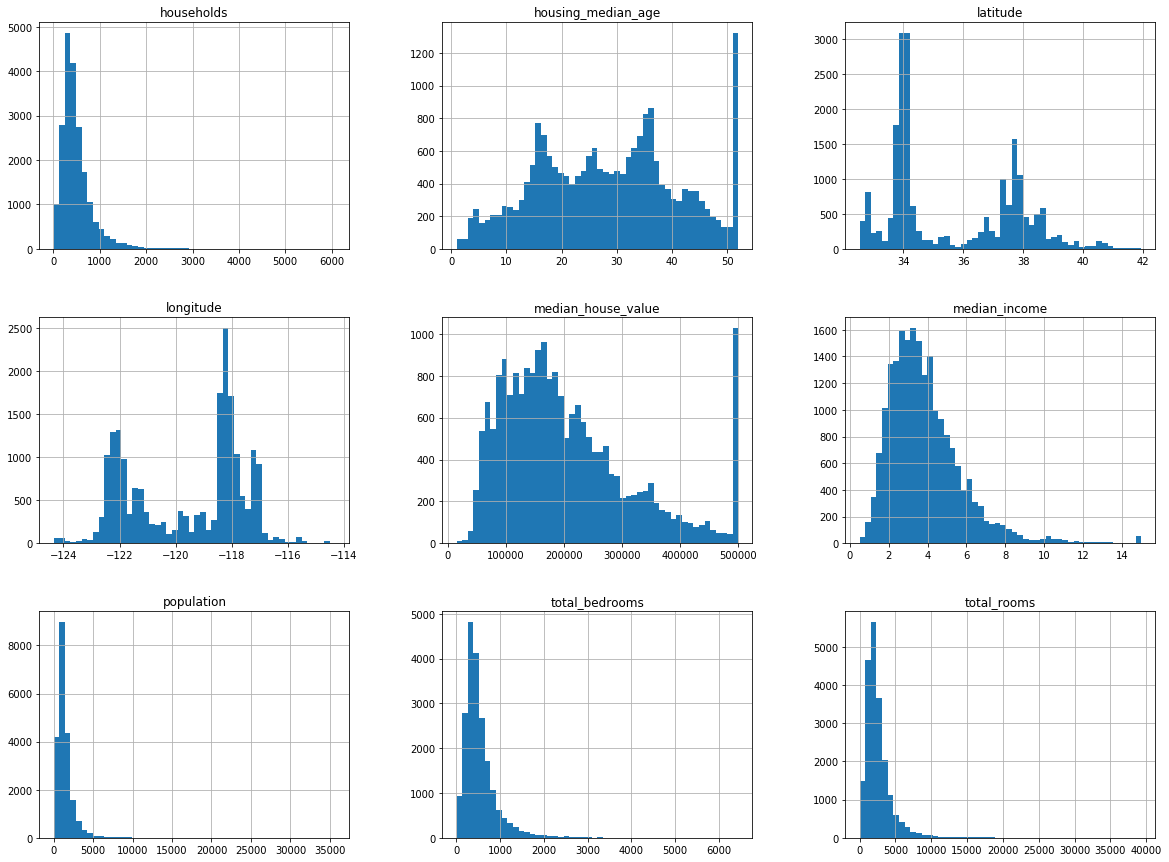

In [18]:
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

In [50]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash = hashlib.md5):
    ids = data[id_column]
    in_test_set =  ids.apply(lambda id_ : test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id["id"] = np.abs(housing["longitude"])*10000 + np.abs(housing["latitude"])
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"id")
print("{} train + {} test".format(len(train_set),len(test_set)))

16458 train + 4182 test


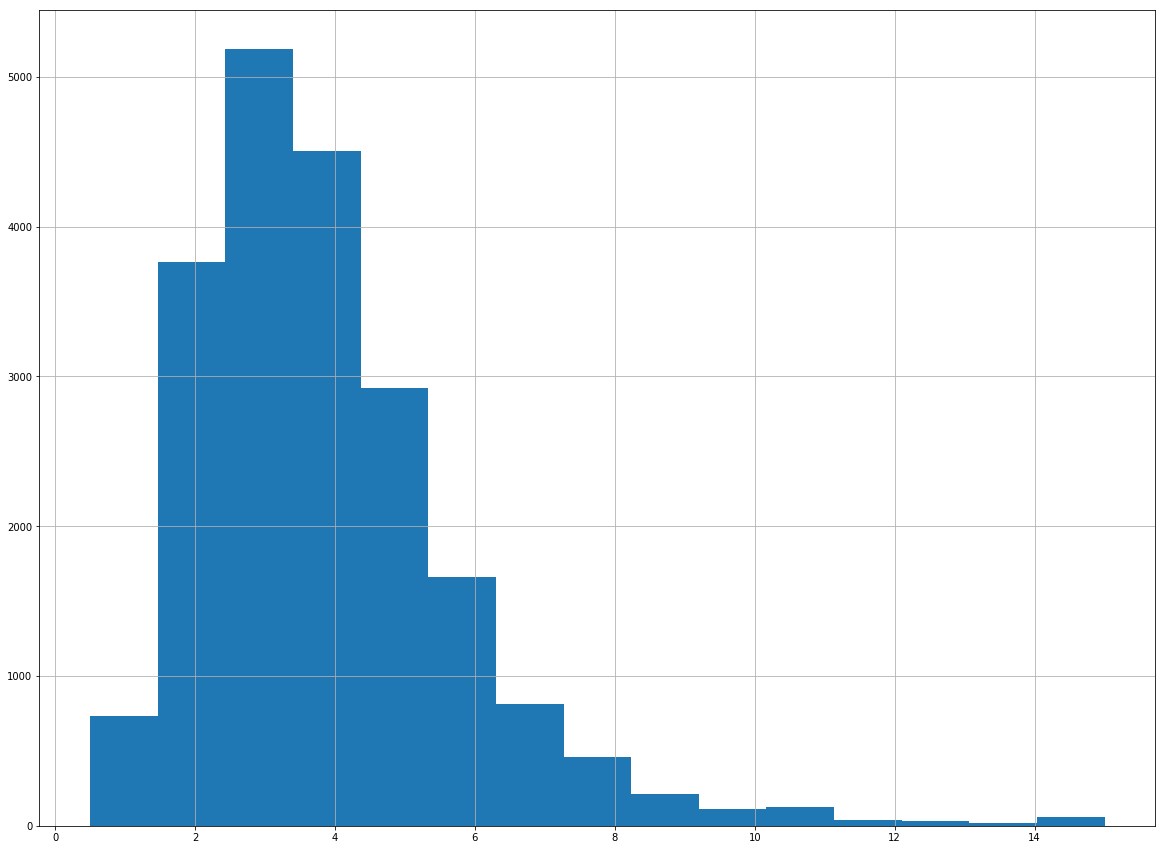

In [39]:
housing["median_income"].hist(bins=15, figsize = (20,15))

In [8]:
#train/test split method based on stratas

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True)

split = SSS(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
housing["income_cat"].value_counts()/len(housing)


3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [45]:
strat_train_set["income_cat"].value_counts()/len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [46]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [47]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis = 1, inplace = True)

In [51]:
housing = strat_train_set.copy()

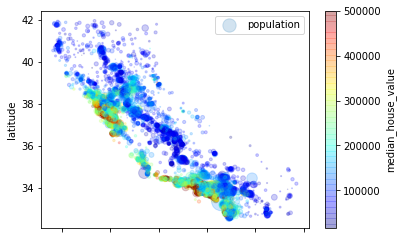

In [64]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.2, 
             s = housing["population"]/100, label = "population",
             c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()

In [66]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FC1F819DA0>,
      dtype=object)

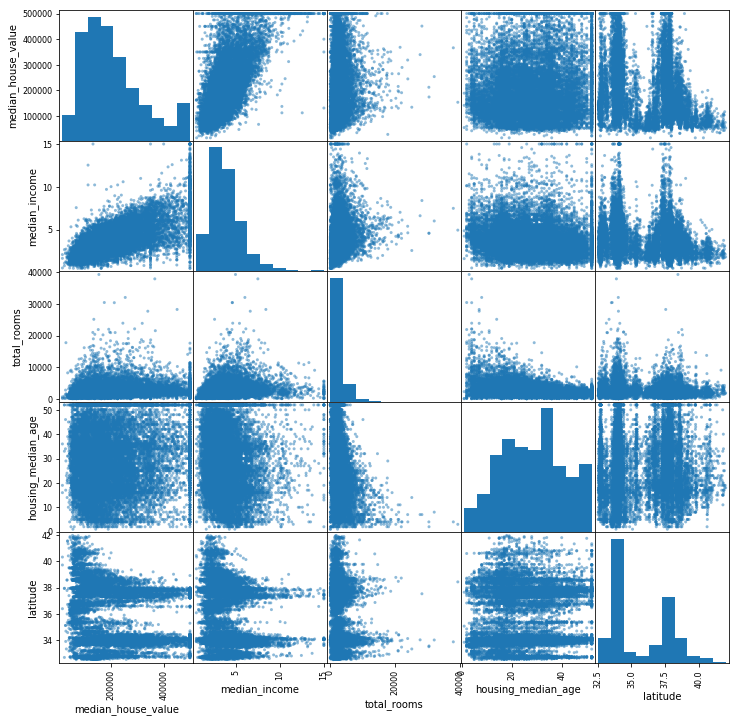

In [73]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age", "latitude"]
scatter_matrix(housing[attributes], figsize = (12, 12))

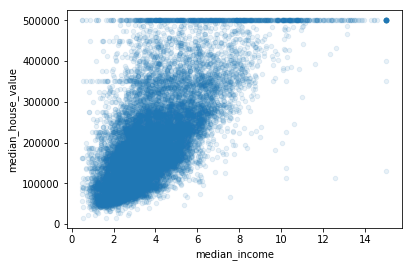

In [74]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

In [77]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["bedrooms_per_household"] = housing["total_bedrooms"]/housing["households"]
housing["populationb_per_households"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value            1.000000
median_income                 0.687160
rooms_per_household           0.146285
total_rooms                   0.135097
housing_median_age            0.114110
households                    0.064506
total_bedrooms                0.047689
populationb_per_households   -0.021985
population                   -0.026920
bedrooms_per_household       -0.043343
longitude                    -0.047432
latitude                     -0.142724
bedrooms_per_room            -0.259984
Name: median_house_value, dtype: float64

In [24]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
income_cat            16512 non-null float64
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [25]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
income_cat            16512 non-null float64
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [30]:
imputer = Imputer(strategy = "median")
housing_num = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)
print(imputer.statistics_)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns)
housing_tr.info()

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409    3.    ]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
income_cat            16512 non-null float64
dtypes: float64(9)
memory usage: 1.1 MB


In [46]:
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)
print(encoder.classes_)
encoder = OneHotEncoder(categories = 'auto')
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
print(housing_cat_1hot.toarray())

[0 0 4 ... 1 0 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [47]:
encoder = LabelBinarizer(sparse_output = True)
housing_cat_1hot = encoder.fit_transform(housing_cat)